In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, models

from sklearn.metrics import classification_report
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
from tabulate import tabulate

import os
import glob
import json
import shutil

from PIL import Image, ImageDraw

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader



In [2]:
class Config:
    def __init__(self):
        self.image_width = 128
        self.image_height = 128
        self.epoch = 15
        self.seed = 42
        self.batch_size = 64
        self.dataset_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'        

In [3]:
config = Config()

print("Checking Epoch Configuration:", config.epoch)

Checking Epoch Configuration: 15


##### Dataset to dataframe

In [4]:
dataset = {"image_path":[],"img_status":[],"where":[]}

for where in os.listdir(config.dataset_path):
    for status in os.listdir(config.dataset_path+"/"+where):
        for image in glob.glob(os.path.join(config.dataset_path, where, status, "*.jpg")):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append(where)

dataset = pd.DataFrame(dataset)

In [5]:
dataset = shuffle(dataset)
dataset = dataset.reset_index(drop=True)
dataset.head(10)

image_path img_status  where
0  /kaggle/input/140k-real-and-fake-faces/real_vs...       fake  train
1  /kaggle/input/140k-real-and-fake-faces/real_vs...       fake   test
2  /kaggle/input/140k-real-and-fake-faces/real_vs...       real  train
3  /kaggle/input/140k-real-and-fake-faces/real_vs...       fake   test
4  /kaggle/input/140k-real-and-fake-faces/real_vs...       fake  train
5  /kaggle/input/140k-real-and-fake-faces/real_vs...       real  valid
6  /kaggle/input/140k-real-and-fake-faces/real_vs...       real  valid
7  /kaggle/input/140k-real-and-fake-faces/real_vs...       fake  train
8  /kaggle/input/140k-real-and-fake-faces/real_vs...       fake   test
9  /kaggle/input/140k-real-and-fake-faces/real_vs...       real  train

##### EDA Analysis

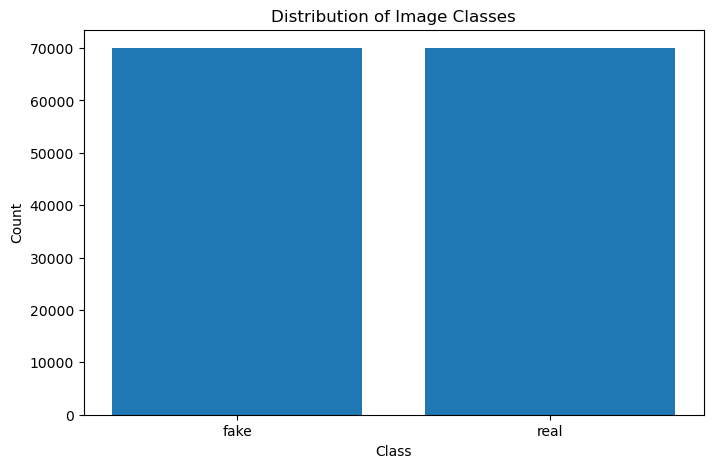

In [6]:
status_counts = dataset["img_status"].value_counts()
plt.figure(figsize=(8, 5))
plt.bar(status_counts.index, status_counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Image Classes")
plt.show()

###### Loading the image

In [7]:
def load_image(dataset, img_status):
    plt.figure(figsize=(20, 10))

    # Path of the image
    images = dataset[dataset['img_status'] == img_status].sample(4)

    for i in range(4):
        plt.subplot(2, 4, i+1)
        plt.imshow(plt.imread(images["image_path"].values[i]))
        # Img_status
        plt.title(img_status, size=10)
        plt.xticks([])
        plt.yticks([])

    plt.show()

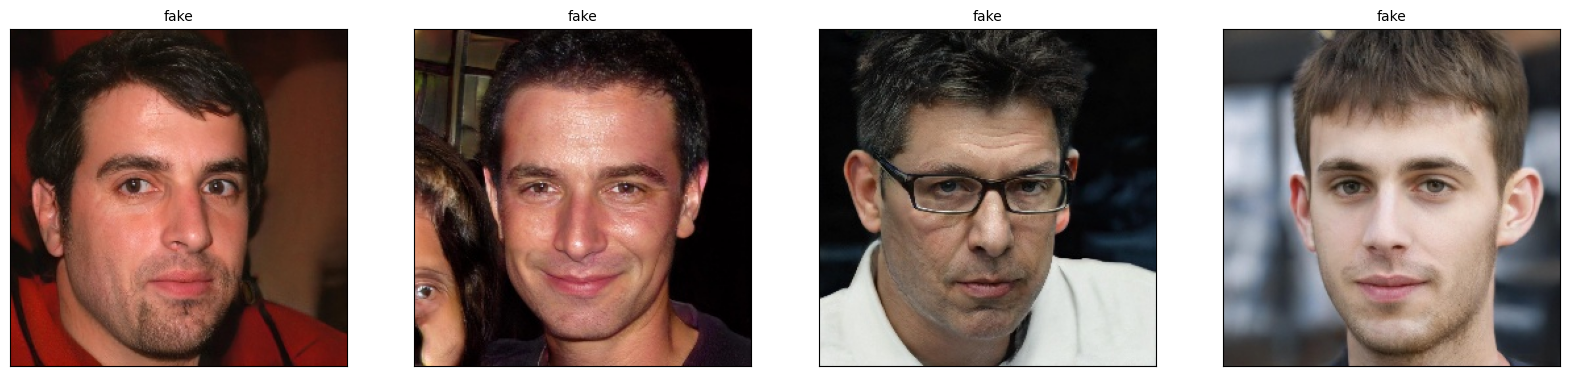

In [8]:
load_image(dataset, "fake")

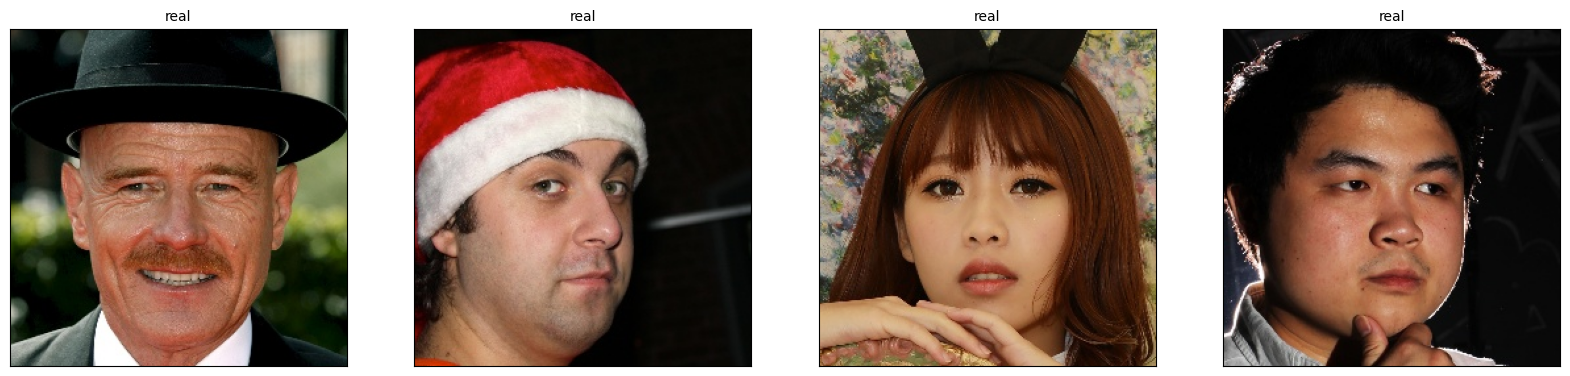

In [9]:
load_image(dataset, "real")

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Device: {device}")

Device: cuda


##### Data Augmentation

In [11]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(os.path.join(config.dataset_path, 'train'), transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

valid_dataset = ImageFolder(os.path.join(config.dataset_path, 'valid'), transform=val_test_transform)
valid_loader = DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)

test_dataset = ImageFolder(os.path.join(config.dataset_path, 'test'), transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

In [12]:
print("Train Dataset: ", train_dataset)
print("Train Loader: ", train_loader)

Train Dataset:  Dataset ImageFolder
    Number of datapoints: 100000
    Root location: /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Train Loader:  <torch.utils.data.dataloader.DataLoader object at 0x7f1224e1c8b0>


In [13]:
print("Valid Dataset: ", valid_dataset)
print("Valid Loader: ", valid_loader)

Valid Dataset:  Dataset ImageFolder
    Number of datapoints: 20000
    Root location: /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Valid Loader:  <torch.utils.data.dataloader.DataLoader object at 0x7f1224d9e0b0>


In [14]:
print("Test Dataset: ", test_dataset)
print("Test Loader: ", test_loader)

Test Dataset:  Dataset ImageFolder
    Number of datapoints: 20000
    Root location: /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test Loader:  <torch.utils.data.dataloader.DataLoader object at 0x7f1224d9e0e0>


##### Displaying Augmented images

In [15]:
def show_augmented_images(loader):
    images, labels = next(iter(loader))

    label_names = ['Fake', 'Real']
    label_names = [label_names[label] for label in labels]

    fig, axes = plt.subplots(1, 5)
    axes = axes.ravel()

    for i in range(len(axes)):
        image = images[i].permute(1, 2, 0).cpu().numpy() 
        image = (image - image.min()) / (image.max() - image.min()) 

        axes[i].imshow(image)
        axes[i].axis('off')

        label_index = labels[i].item()
        if label_index < len(label_names):  
            label = label_names[label_index]
        else:
            label = "Unknown"
        axes[i].set_title(label)

    plt.tight_layout()
    plt.show()

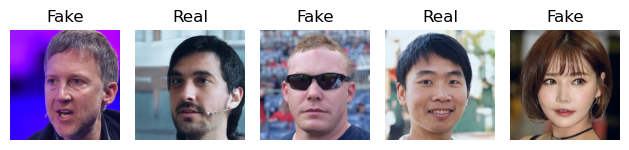

In [16]:
show_augmented_images(train_loader)

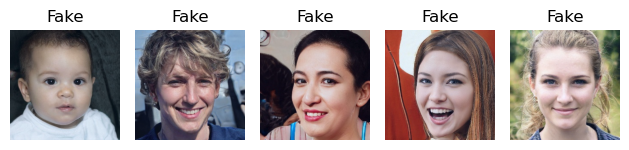

In [17]:
show_augmented_images(valid_loader)

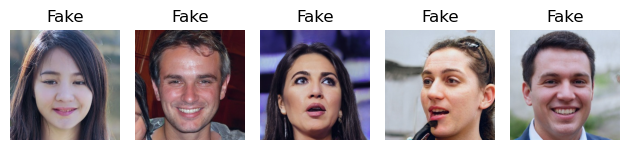

In [18]:
show_augmented_images(test_loader)

##### Model Class

In [19]:
class CustomModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(CustomModel, self).__init__()
        self.model = models.__dict__[model_name](pretrained=True)
        
        if 'vgg' in model_name:
            num_features = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, num_classes)
        )
            
        elif 'mobilenet' in model_name:
            num_features = self.model.classifier[1].in_features
            self.model.classifier = nn.Sequential(
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Linear(512, num_classes)
            )
            
        else:
            num_features = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Linear(512, num_classes)
            )
            
        self.val_loss = []
        self.val_accuracy = []
        self.train_loss = []
        self.train_accuracy = []

    def forward(self, x):
        return self.model(x)

    def print_model_summary(self):
        print(self.model)
        print("Model Summary:")
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Total Parameters: {total_params}")
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Trainable Parameters: {trainable_params}")

    def plot_metrics_graph(self):
        epochs = range(1, len(self.train_loss) + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.train_loss, label='Train Loss', linewidth=2, color='blue')
        plt.plot(epochs, self.val_loss, label='Validation Loss', linewidth=2, color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.train_accuracy, label='Train Accuracy', linewidth=2, color='green')
        plt.plot(epochs, self.val_accuracy, label='Validation Accuracy', linewidth=2, color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

    def train_model(self, train_loader, valid_loader, num_epochs, device):
        criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss
        optimizer = optim.Adam(self.parameters(), lr=0.001)

        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True, min_lr=1e-6)

        for epoch in range(num_epochs):
            self.train()  # Set the model to training mode
            total_loss = 0.0
            correct_train = 0
            total_train = 0

            print(f"Epoch [{epoch+1}/{num_epochs}] - Training...")

            for batch_idx, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels.float().unsqueeze(1))
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * inputs.size(0)
                predicted_labels = (outputs >= 0.0).float()
                correct_train += (predicted_labels == labels.float().unsqueeze(1)).sum().item()
                total_train += labels.size(0)

                print(f"Epoch [{epoch+1}/{num_epochs}] - Batch [{batch_idx+1}/{len(train_loader)}] - "
                      f"Loss: {loss.item():.4f} - Train Accuracy: {correct_train / total_train:.4f}")

            average_loss = total_loss / len(train_loader.dataset)
            train_accuracy = correct_train / total_train

            self.train_loss.append(average_loss)
            self.train_accuracy.append(train_accuracy)

            self.eval()
            total_val_loss = 0.0
            correct_val = 0
            total_val = 0

            y_true = []
            y_pred = []

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)
                    val_loss = criterion(outputs, labels.float().unsqueeze(1))
                    total_val_loss += val_loss.item() * inputs.size(0)
                    predicted_labels = (outputs >= 0.0).float()
                    correct_val += (predicted_labels == labels.float().unsqueeze(1)).sum().item()
                    total_val += labels.size(0)

                    y_true.extend(labels.float().unsqueeze(1).cpu().numpy())
                    y_pred.extend(predicted_labels.cpu().numpy())

            average_val_loss = total_val_loss / len(valid_loader.dataset)
            val_accuracy = correct_val / total_val

            self.val_loss.append(average_val_loss)
            self.val_accuracy.append(val_accuracy)

            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {average_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - "
                  f"Val Loss: {average_val_loss:.4f} - Val Accuracy: {val_accuracy:.4f} - "
                  f"LR: {scheduler.optimizer.param_groups[0]['lr']:.6f}")

            scheduler.step(average_val_loss)
        
        self.plot_metrics_graph()
        self.plot_confusion_matrix(y_true, y_pred)

In [20]:
num_classes = 1  
model_name = "vgg16"  
model = CustomModel(model_name=model_name, num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.print_model_summary()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 263MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch [1/15] - Training...
Epoch [1/15] - Batch [1/1563] - Loss: 0.6993 - Train Accuracy: 0.5625
Epoch [1/15] - Batch [2/1563] - Loss: 0.6704 - Train Accuracy: 0.5938
Epoch [1/15] - Batch [3/1563] - Loss: 0.8670 - Train Accuracy: 0.5625
Epoch [1/15] - Batch [4/1563] - Loss: 1.0865 - Train Accuracy: 0.5273
Epoch [1/15] - Batch [5/1563] - Loss: 0.7650 - Train Accuracy: 0.5500
Epoch [1/15] - Batch [6/1563] - Loss: 0.9949 - Train Accuracy: 0.5443
Epoch [1/15] - Batch [7/1563] - Loss: 1.0942 - Train Accuracy: 0.5379
Epoch [1/15] - Batch [8/1563] - Loss: 1.0794 - Train Accuracy: 0.5234
Epoch [1/15] - Batch [9/1563] - Loss: 0.9833 - Train Accuracy: 0.5243
Epoch [1/15] - Batch [10/1563] - Loss: 1.1448 - Train Accuracy: 0.5094
Epoch [1/15] - Batch [11/1563] - Loss: 1.0920 - Train Accuracy: 0.5043
Epoch [1/15] - Batch [12/1563] - Loss: 0.7731 - Train Accuracy: 0.5091
Epoch [1/15] - Batch [13/1563] - Loss: 1.1301 - Train Accuracy: 0.4988
Epoch [1/15] - Batch [14/1563] - Loss: 0.8368 - Train Accur

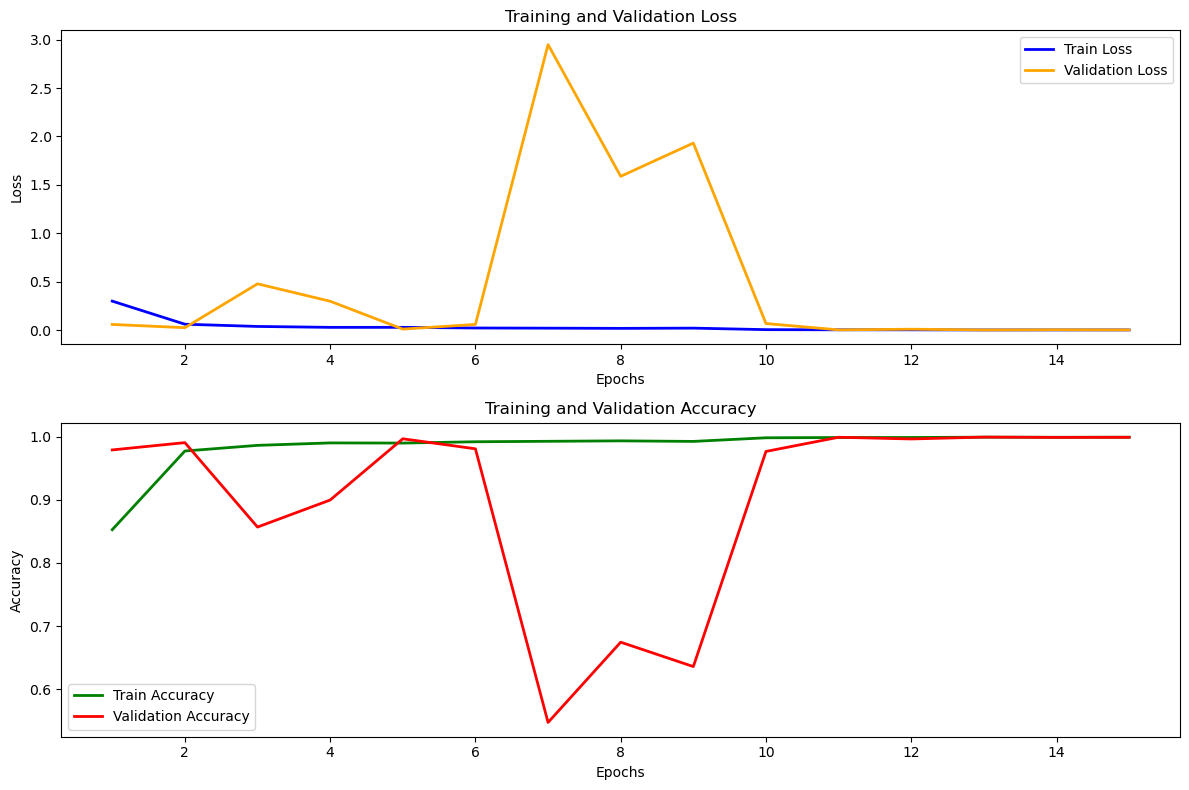

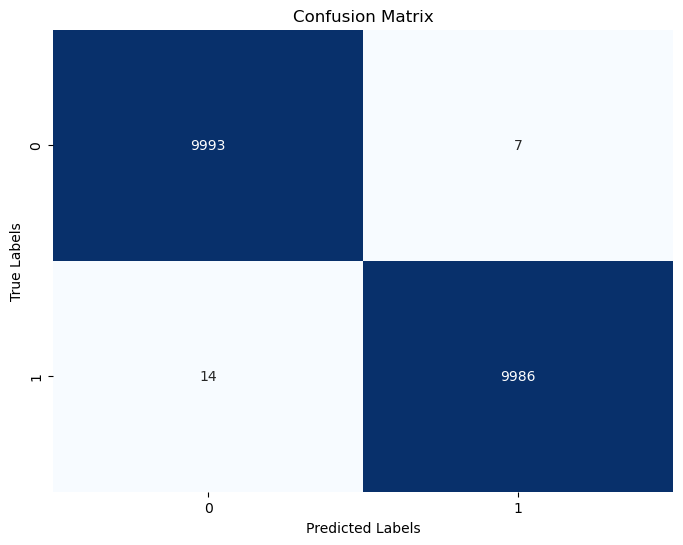

In [21]:
num_epochs = config.epoch
model.train_model(train_loader, valid_loader, num_epochs, device)